In [52]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Conv2D, Dense, GlobalAveragePooling2D, Dropout, Activation, MaxPooling2D, Flatten
from keras import backend as K
from keras.optimizers import SGD
from keras import Sequential

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

# OMP: Error #15: Initializing libiomp5.dylib, but found libiomp5.dylib already initialized.
# OMP: Hint: This means that multiple copies of the OpenMP runtime have been linked into the program. 
# That is dangerous, since it can degrade performance or cause incorrect results. 
# The best thing to do is to ensure that only a single OpenMP runtime is linked into the process,
# e.g. by avoiding static linking of the OpenMP runtime in any library. 
# As an unsafe, unsupported, undocumented workaround you can set the 
# environment variable KMP_DUPLICATE_LIB_OK=TRUE to allow the program to continue to execute, 
# but that may cause crashes or silently produce incorrect results. 
# For more information, please see http://www.intel.com/software/products/support/.
# >>>   https://github.com/dmlc/xgboost/issues/1715
# >>>   https://stackoverflow.com/questions/53014306/error-15-initializing-libiomp5-dylib-but-found-libiomp5-dylib-already-initial
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# Load Data and Data Augumentation

### Example


```python
# Data augumentation example
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

img = load_img('resources/data/food-101/data/train/cheesecake/72295.jpg')  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
for batch in datagen.flow(x, batch_size=1,
                          save_to_dir='resources/gen-data', 
                          save_prefix='cheesecake', 
                          save_format='jpeg'):
    i += 1
    if i > 20:
        break  # otherwise the generator would loop indefinitely
```

In [93]:
base_path="../../.."
data_path=f"{base_path}/data/generated"
dataset_name = "food-004-0.1"

train_path = f"{data_path}/{dataset_name}/data/train"
test_path = f"{data_path}/{dataset_name}/data/validation"
validation_path = f"{data_path}/{dataset_name}/data/test"

# Configuration
height = 150
width = 150
n_channels = 3 # RGB
batch_size = 16

input_shape = (n_channels, width, height) if K.image_data_format() == 'channels_first' else (width, height, n_channels)

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rotation_range=40,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=(height, width),
        color_mode='rgb',
        batch_size=batch_size,
        class_mode='categorical',
        seed=seed)  # because categorical_crossentropy loss

val_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = val_datagen.flow_from_directory(
        validation_path,
        target_size=(height, width),
        color_mode='rgb',
        batch_size=batch_size,
        class_mode='categorical',
        seed=seed)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_path,
        target_size=(height, width),
        color_mode='rgb',
        batch_size=batch_size,
        class_mode='categorical',
        seed=seed)


# TODO: get from data generator
n_classes = len(np.unique(train_generator.classes))
n_train_samples = len(train_generator.classes)
n_validation_samples = len(validation_generator.classes)
n_test_samples = len(test_generator.classes)


print("=========================")
print("    Dataset summary:")
print("=========================")
print(f"classes: {n_classes}")
print(f"training examples: {n_train_samples}")
print(f"validation examples: {n_validation_samples}")
print(f"test examples: {n_test_samples}")


Found 272 images belonging to 4 classes.
Found 28 images belonging to 4 classes.
Found 100 images belonging to 4 classes.
    Dataset summary:
classes: 4
training examples: 272
validation examples: 28
test examples: 100


# Custom Callbacks and utility functions

In [94]:
class plot_train_progress(keras.callbacks.Callback):
    def __init__(self, plot_every_n_epochs = 5, plot_fraction = 0.9):
        self.plot_frequency = plot_every_n_epochs
        self.plot_fraction = plot_fraction #Plot only the most recent values
        
    def on_train_begin(self, logs={}):
        self.train_losses = []
        self.train_acc = []
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.train_losses.append(logs.get('loss'))
        self.train_acc.append(logs.get('acc'))
            
        if epoch % self.plot_frequency == 0:
            # You can chose the style of your preference
            # print(plt.style.available) to see the available options
            plt.style.use("seaborn")
            
            nr_values_to_plot = int(self.plot_fraction * len(self.train_losses))
            if nr_values_to_plot > 1:
                t = list(range(nr_values_to_plot))
                plt.plot(t, self.train_losses[-nr_values_to_plot:], label = "train_loss")
                plt.plot(t, self.train_acc[-nr_values_to_plot:], label = "train_acc")
                plt.title("Training Loss and Accuracy [Epoch {}]".format(epoch))
                plt.xlabel('# Batches')
                plt.ylabel('Loss/Accuracy')
                plt.legend()
                #plt.savefig('train_progress.jpg')
                plt.show()

    def on_batch_end(self, batch, logs={}):
        self.train_losses.append(logs.get('loss'))
        self.train_acc.append(logs.get('acc'))

        
def plot_history(history, metric, title, ylabel, xlabel):
    plt.plot(history.history[metric])
    plt.plot(history.history[f"val_{metric}"])
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


def visualize_model_predictions(model, classes, test_set, y_test, y_hat, title_string):
    # Plot a random sample of 10 test images, their predicted labels and ground truth
    figure = plt.figure(figsize=(40, 40))
    n_instances = test_set.shape[0]
    for i, index in enumerate(np.random.choice(n_instances, size=n_instances, replace=False)):
        ax = figure.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
        # Display each image
        ax.imshow(np.squeeze(test_set[index]), cmap = 'gray')
        predict_index = np.argmax(y_hat[index])
        true_index = np.argmax(y_test[index])
        # Set the title for each image
        ax.set_title("{} ({})".format(classes[predict_index], 
                                      classes[true_index]),
                                      color=("green" if predict_index == true_index else "red"),
                                      fontsize=45)
    figure.suptitle("%s results:" %title_string, fontsize=25)


## Model definition

In [95]:
optimizer='rmsprop'
model_to_use='simple'


# TODO:
# TensorBoard callback
# Email notification callback

checkpointer = ModelCheckpoint(filepath="model.weights.best.hdf5", verbose = 1, save_best_only=True)
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
callbacks_list = [checkpointer, plot_train_progress(5, .9), earlyStopping]

if model_to_use == 'inception':
    # Model definition
    base_model = InceptionV3(
        include_top=False, 
        weights='imagenet', 
        input_shape=(width, height, n_channels)) #input_tensor=None
    x = base_model.output
    x = GlobalAveragePooling2D()(x) # or: pooling='avg'
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(n_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
   
    # first: freeze all convolutional InceptionV3 layers
    for layer in base_model.layers:
        layer.trainable = False
        
elif model_to_use == 'custom-inception':
    base_model = InceptionV3(
        include_top=False, 
        weights='imagenet', 
        input_shape=(width, height, n_channels)) #input_tensor=None

    x = base_model.output
    x = GlobalAveragePooling2D()(x) # or: pooling='avg'
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(n_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    # train the top 2 inception blocks
    for layer in model.layers[:249]:
       layer.trainable = False
    for layer in model.layers[249:]:
       layer.trainable = True

    optimizer=SGD(lr=0.0001, momentum=0.9)
    checkpointer = ModelCheckpoint(filepath="model.weights.best.hdf5_tunning", verbose = 1, save_best_only=True)
    callbacks_list = [checkpointer, plot_train_progress(5, 1), earlyStopping]
else:
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=input_shape, padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.3))

    model.add(Dense(n_classes))
    model.add(Activation('softmax'))

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Take a look at the model summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 150, 150, 32)      896       
_________________________________________________________________
activation_43 (Activation)   (None, 150, 150, 32)      0         
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 73, 73, 64)        18496     
_________________________________________________________________
activation_44 (Activation)   (None, 73, 73, 64)        0         
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 34, 34, 32)        18464     
__________

## Train

Epoch 1/10
17/17 [==============================] - 5s 278ms/step - loss: 1.4207 - acc: 0.2904 - val_loss: 1.4070 - val_acc: 0.1875

Epoch 00001: val_loss improved from inf to 1.40702, saving model to model.weights.best.hdf5


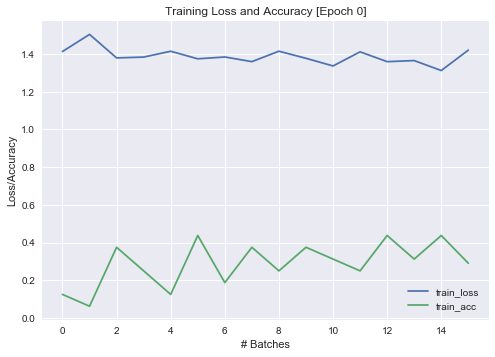

Epoch 2/10
17/17 [==============================] - 3s 169ms/step - loss: 1.3626 - acc: 0.3529 - val_loss: 1.2824 - val_acc: 0.4167

Epoch 00002: val_loss improved from 1.40702 to 1.28239, saving model to model.weights.best.hdf5
Epoch 3/10
17/17 [==============================] - 3s 173ms/step - loss: 1.3259 - acc: 0.3493 - val_loss: 1.2361 - val_acc: 0.3750

Epoch 00003: val_loss improved from 1.28239 to 1.23614, saving model to model.weights.best.hdf5
Epoch 4/10
17/17 [==============================] - 3s 173ms/step - loss: 1.3044 - acc: 0.4118 - val_loss: 1.3109 - val_acc: 0.5000

Epoch 00004: val_loss did not improve from 1.23614
Epoch 5/10
17/17 [==============================] - 3s 182ms/step - loss: 1.2742 - acc: 0.3787 - val_loss: 1.2746 - val_acc: 0.5000

Epoch 00005: val_loss did not improve from 1.23614
Epoch 6/10
17/17 [==============================] - 3s 173ms/step - loss: 1.2473 - acc: 0.4154 - val_loss: 1.3004 - val_acc: 0.4167

Epoch 00006: val_loss did not improve fro

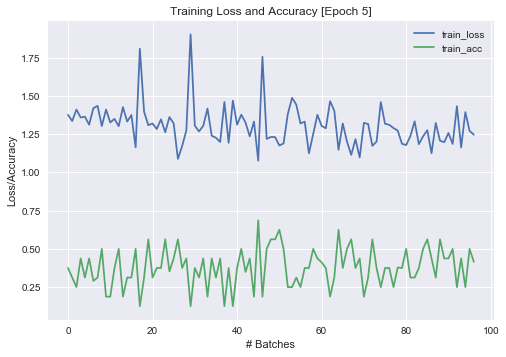

Epoch 7/10
17/17 [==============================] - 3s 175ms/step - loss: 1.2599 - acc: 0.4449 - val_loss: 1.3545 - val_acc: 0.5000

Epoch 00007: val_loss did not improve from 1.23614
Epoch 8/10
17/17 [==============================] - 3s 175ms/step - loss: 1.2241 - acc: 0.4007 - val_loss: 1.1841 - val_acc: 0.3333

Epoch 00008: val_loss improved from 1.23614 to 1.18407, saving model to model.weights.best.hdf5
Epoch 9/10
17/17 [==============================] - 3s 176ms/step - loss: 1.2080 - acc: 0.4412 - val_loss: 1.1694 - val_acc: 0.4375

Epoch 00009: val_loss improved from 1.18407 to 1.16942, saving model to model.weights.best.hdf5
Epoch 10/10
17/17 [==============================] - 3s 182ms/step - loss: 1.2311 - acc: 0.4632 - val_loss: 1.3159 - val_acc: 0.3333

Epoch 00010: val_loss did not improve from 1.16942


In [96]:
n_epochs=10

#model.fit(x_train_color, y_train_color,
#          batch_size=128,
#          epochs=10,
#          validation_data=(x_valid_color, y_valid_color),
#          callbacks=callbacks_list)

history = model.fit_generator(
        train_generator,
        epochs=n_epochs,
        steps_per_epoch = n_train_samples // batch_size,
        validation_data = validation_generator,
        validation_steps = n_validation_samples // batch_size,
        callbacks=callbacks_list)






Training history:


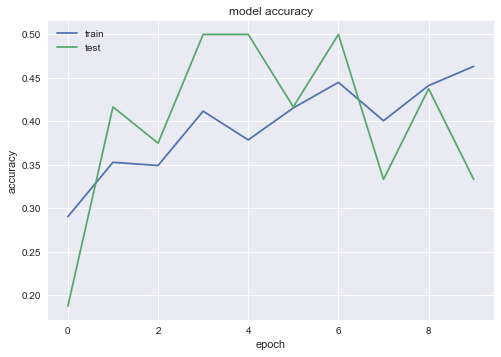

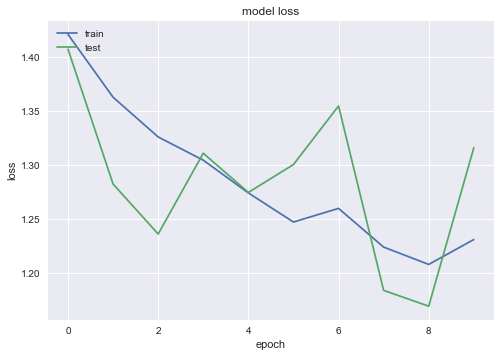

In [97]:


# list all data in history
print("\n\nTraining history:")

# summarize history for accuracy
plot_history(history, 'acc', 'model accuracy', 'accuracy', 'epoch')

# summarize history for loss
plot_history(history, 'loss', 'model loss', 'loss', 'epoch')


# Evaluation

## Model evaluation - test set

In [100]:
model.load_weights('model.weights.best.hdf5')
test_score = model.evaluate_generator(test_generator, steps=len(test_generator), workers=4)

print(f"Loss: {test_score[0]} ; Acc: {test_score[1]}")

Loss: 1.1842661428451537 ; Acc: 0.47


## Test set prediction

In [101]:
test_prediction = model.predict_generator(test_generator, steps=len(test_generator), workers=4)

In [102]:
# test_generator.classes
len(test_prediction)

100

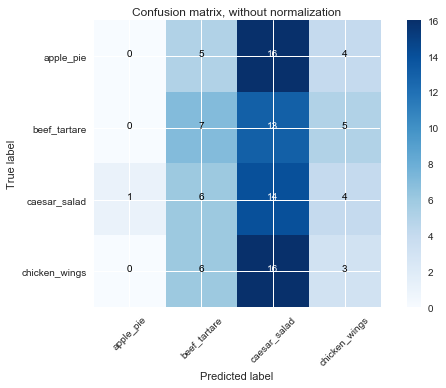

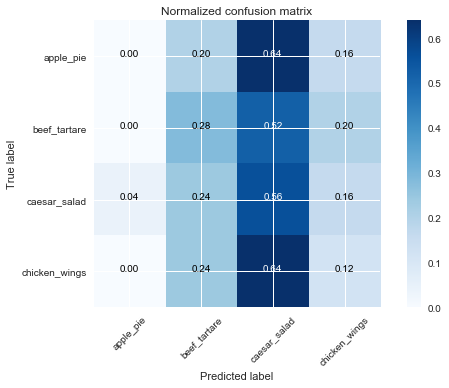

In [104]:

# To avoid rely on the dictionay keys order (e.g. dataset_labels = test_generator.class_indices.keys()),
# first invert the class_indices dictionary and then generate the orderted list of labels
#
dataset_labels_inverted = {v: k for k, v in test_generator.class_indices.items()}
dataset_labels = [dataset_labels_inverted[k] for k in sorted(dataset_labels_inverted.keys())]

y_pred=test_prediction
y_pred_integers = np.argmax(y_pred, axis = 1)
# print(y_pred_integers)

true_labels = test_generator.classes
# print(true_labels)


# Compute confusion matrix
cnf_matrix = confusion_matrix(true_labels, y_pred_integers)

np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=dataset_labels,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=dataset_labels, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

## Visualize classification for a batch test data

Test set true labels:
['caesar_salad', 'chicken_wings', 'apple_pie', 'beef_tartare', 'chicken_wings', 'caesar_salad', 'apple_pie', 'chicken_wings', 'chicken_wings', 'chicken_wings', 'apple_pie', 'chicken_wings', 'caesar_salad', 'caesar_salad', 'beef_tartare', 'apple_pie']


Test set predictions:
['caesar_salad', 'chicken_wings', 'chicken_wings', 'beef_tartare', 'beef_tartare', 'caesar_salad', 'caesar_salad', 'chicken_wings', 'beef_tartare', 'beef_tartare', 'caesar_salad', 'caesar_salad', 'caesar_salad', 'caesar_salad', 'chicken_wings', 'beef_tartare']


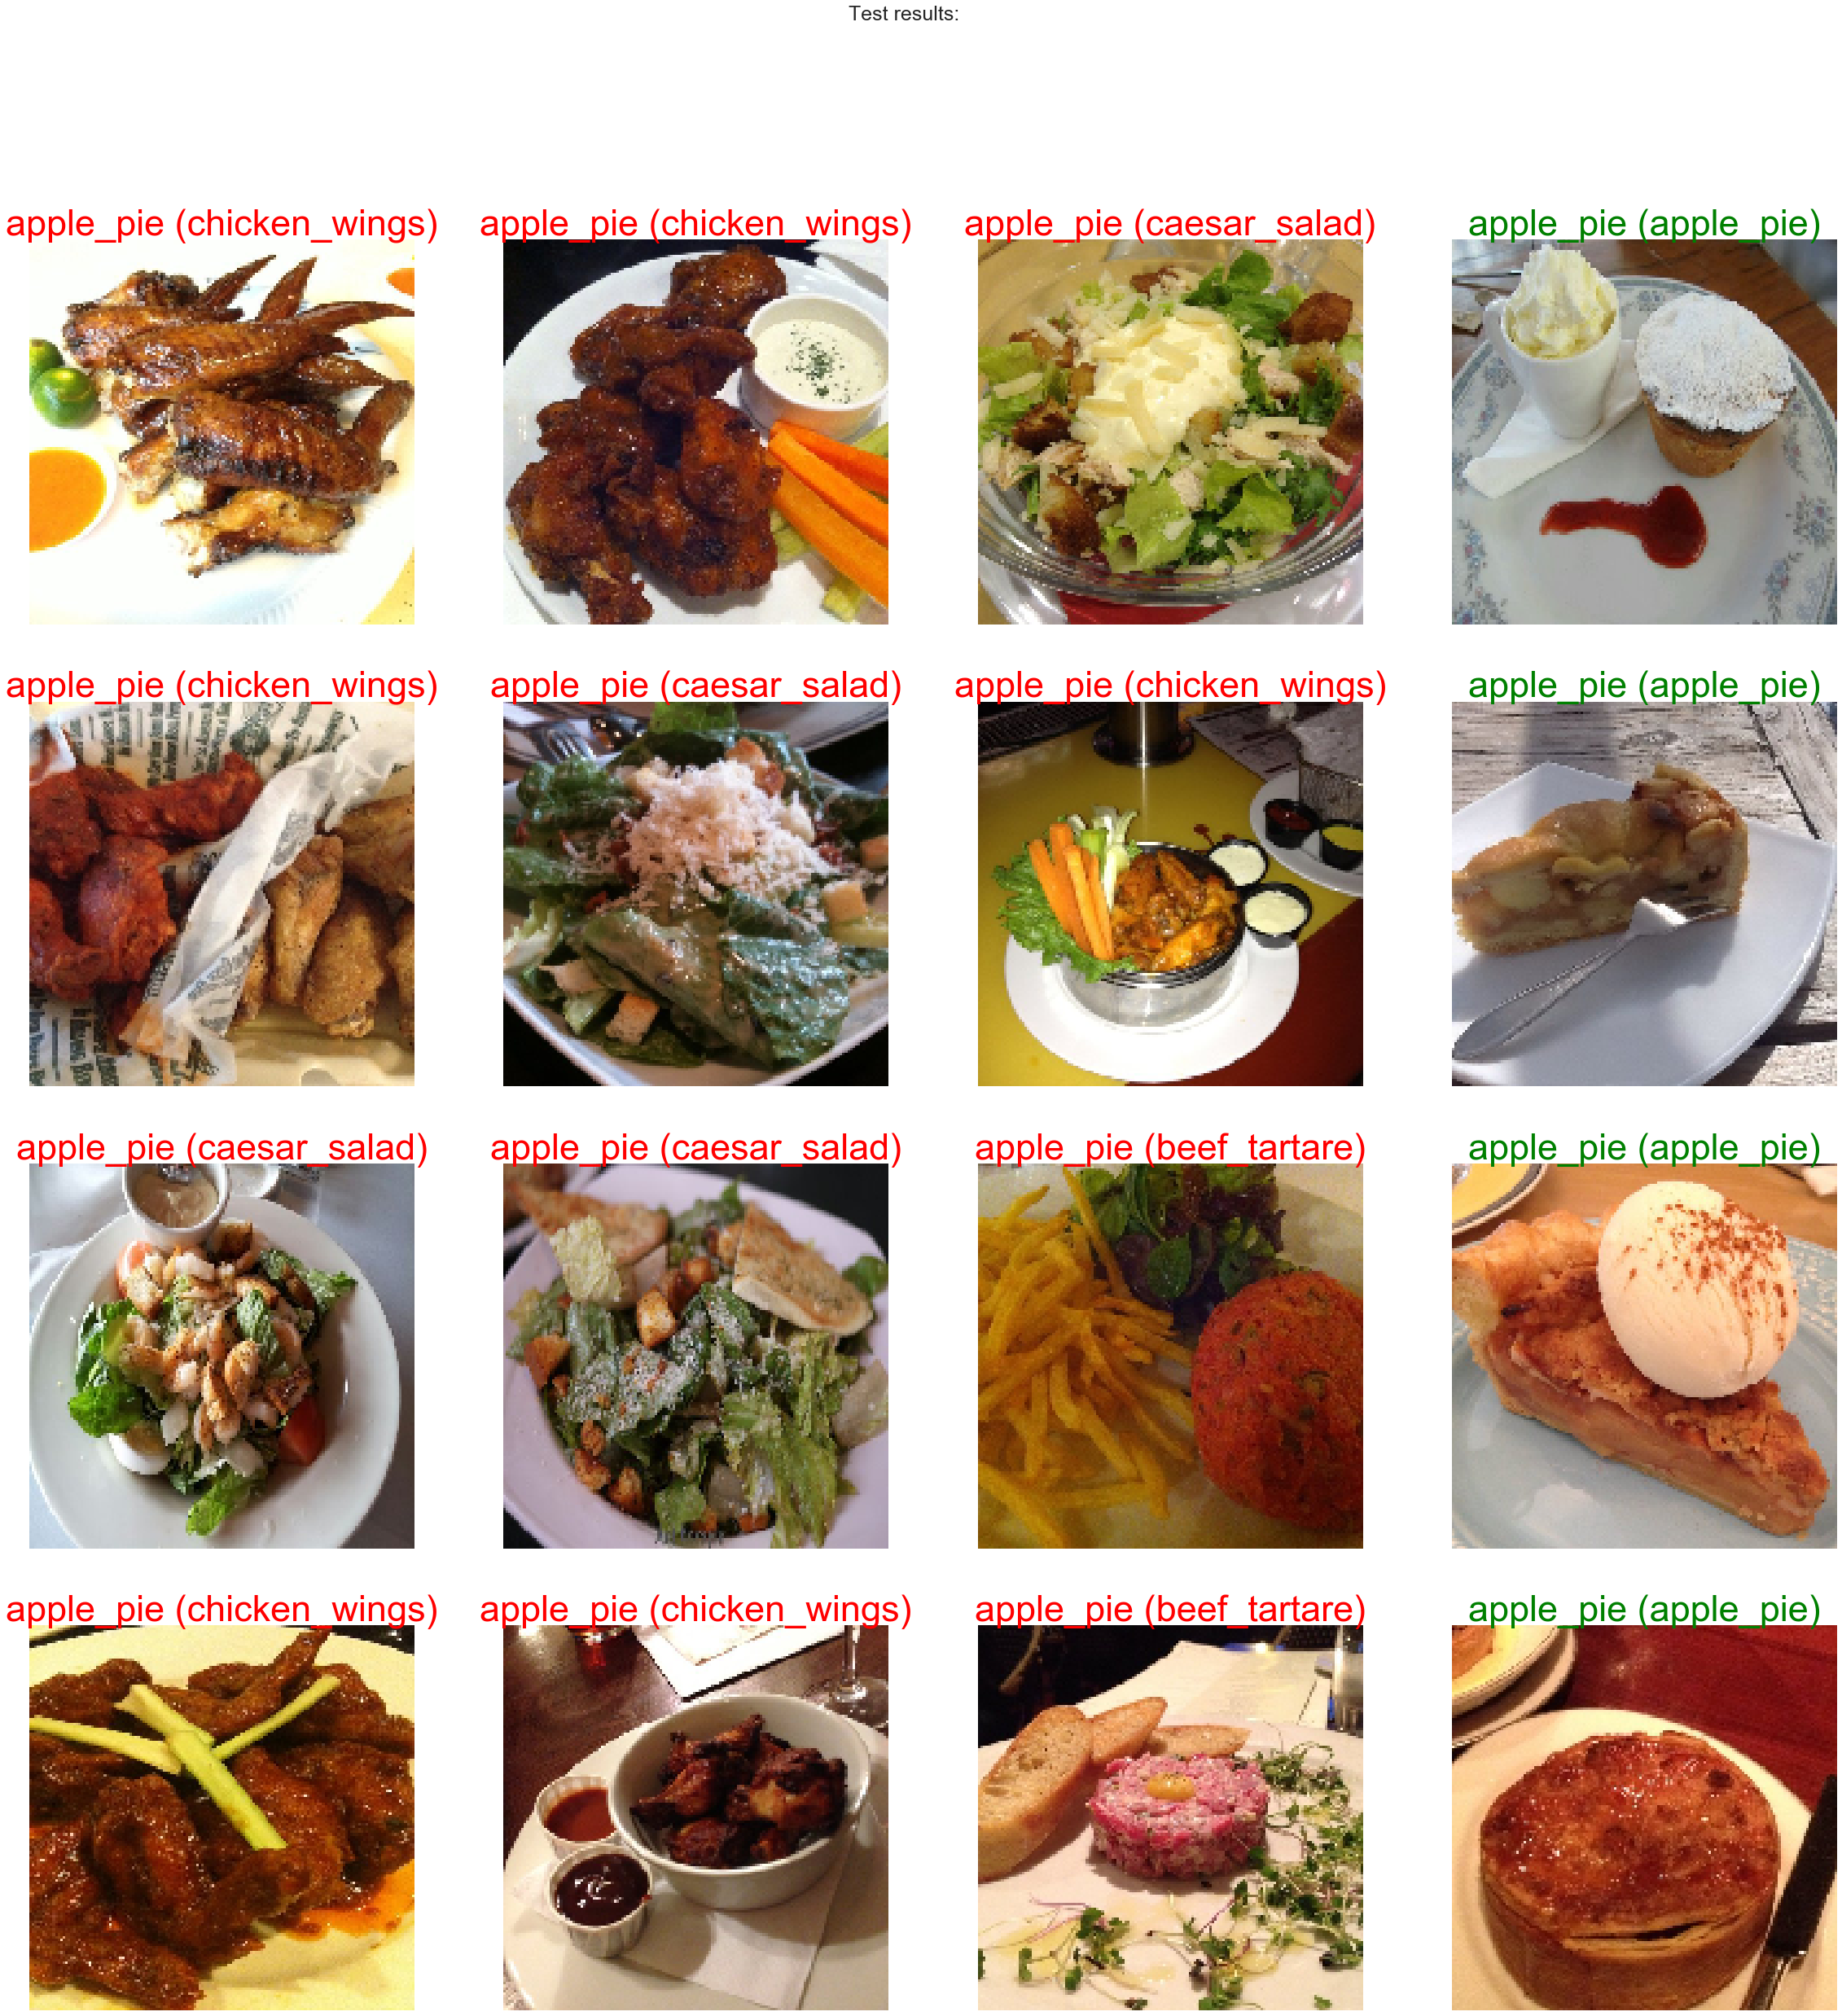

In [105]:
test_set, y = test_generator.next()
y_hat = model.predict(test_set).argmax(axis=-1)

labels = [dataset_labels[c.argmax(axis=-1)] for c in y]
predictions = [dataset_labels[c] for c in y_hat]

print("Test set true labels:")
print(labels)

print("\n\nTest set predictions:")
print(predictions)

visualize_model_predictions(model, dataset_labels, test_set, y, y_hat, 'Test')